Initial analysis to undetstand contents and trends within data

  ingredient strength dosage_form    originator_brand  \
0   Abacavir    300mg      tablet  Virol 300mg Tablet   
1   Abacavir    300mg      tablet  Virol 300mg Tablet   
2   Abacavir    300mg      tablet  Virol 300mg Tablet   
3   Abacavir    600mg      tablet        Inbec Tablet   
4   Abacavir    600mg      tablet        Inbec Tablet   

             originator_manufacturer  originator_price        generic_brand  \
0  Sun Pharmaceutical Industries Ltd           7215.00       Abamune Tablet   
1  Sun Pharmaceutical Industries Ltd           7215.00         A-Bec Tablet   
2  Sun Pharmaceutical Industries Ltd           7215.00  ABHOPE 300MG TABLET   
3         Emcure Pharmaceuticals Ltd           5832.85       Albavir Tablet   
4         Emcure Pharmaceuticals Ltd           5832.85       Albavir Tablet   

            generic_manufacturer  generic_price  price_difference  \
0                      Cipla Ltd        1550.64           5664.36   
1     Emcure Pharmaceuticals Ltd        1588

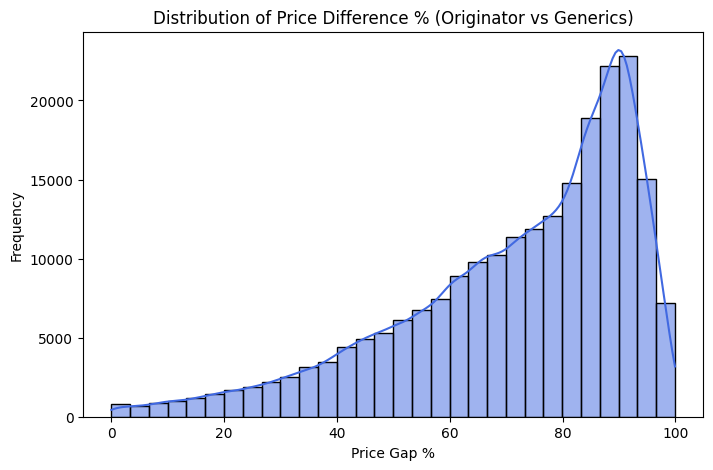

/tmp/ipython-input-3321541972.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_originators, x="num_drugs", y="originator_manufacturer", palette="Blues_r")


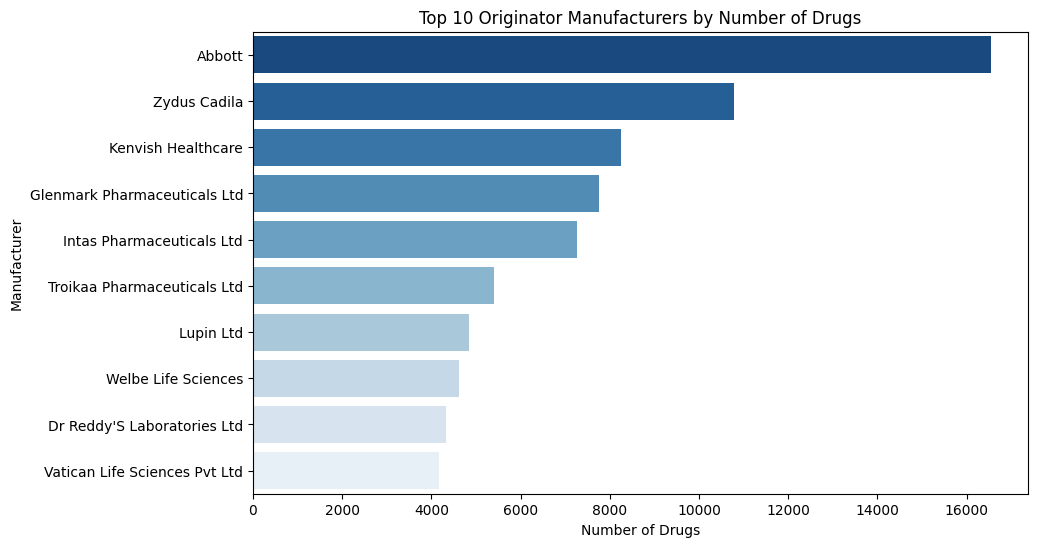

/tmp/ipython-input-3321541972.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_generics, x="num_generics", y="generic_manufacturer", palette="Greens_r")


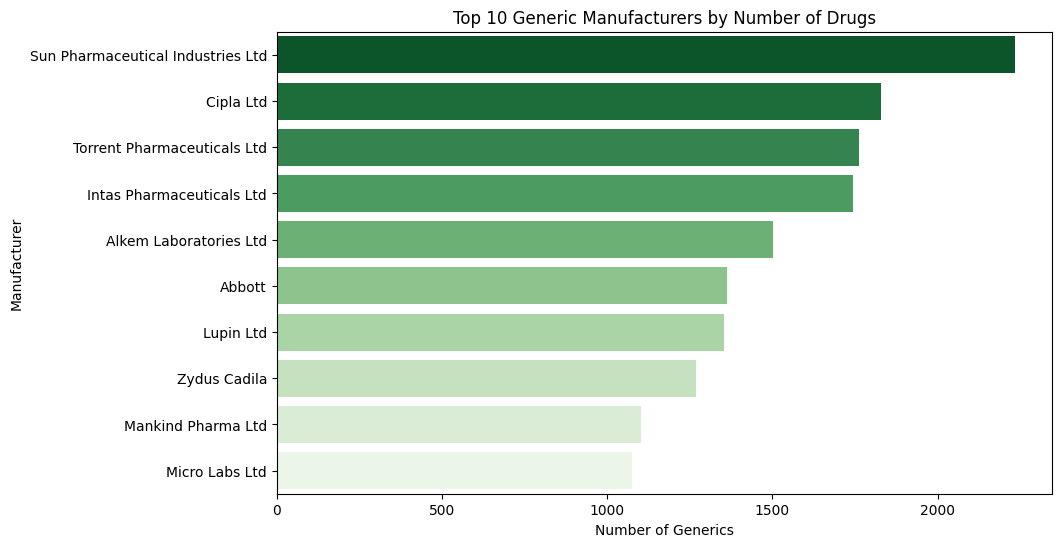

/tmp/ipython-input-3321541972.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ingredient_counts, x="generic_brand", y="ingredient", palette="magma")


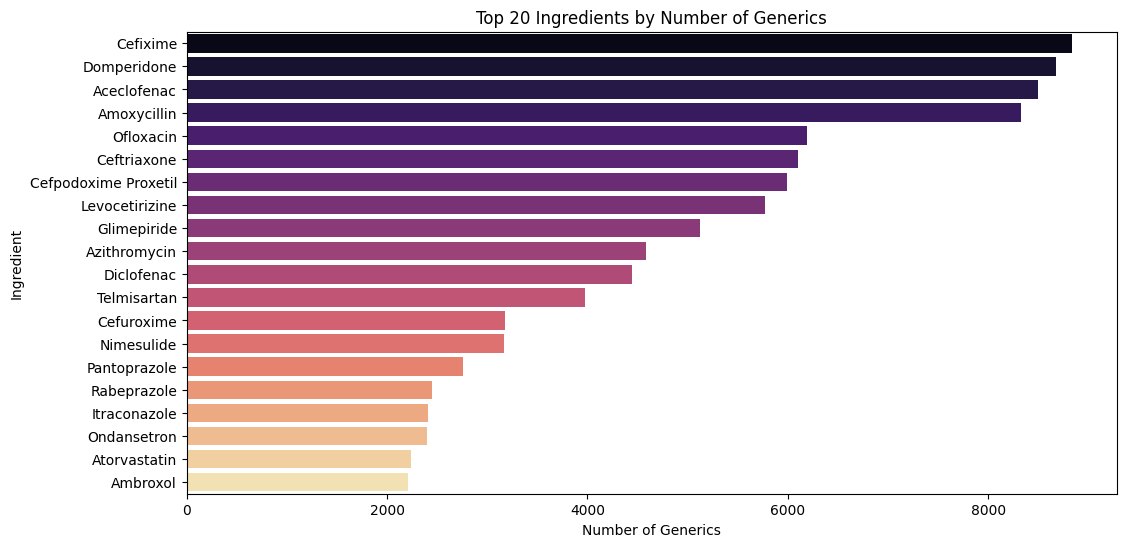

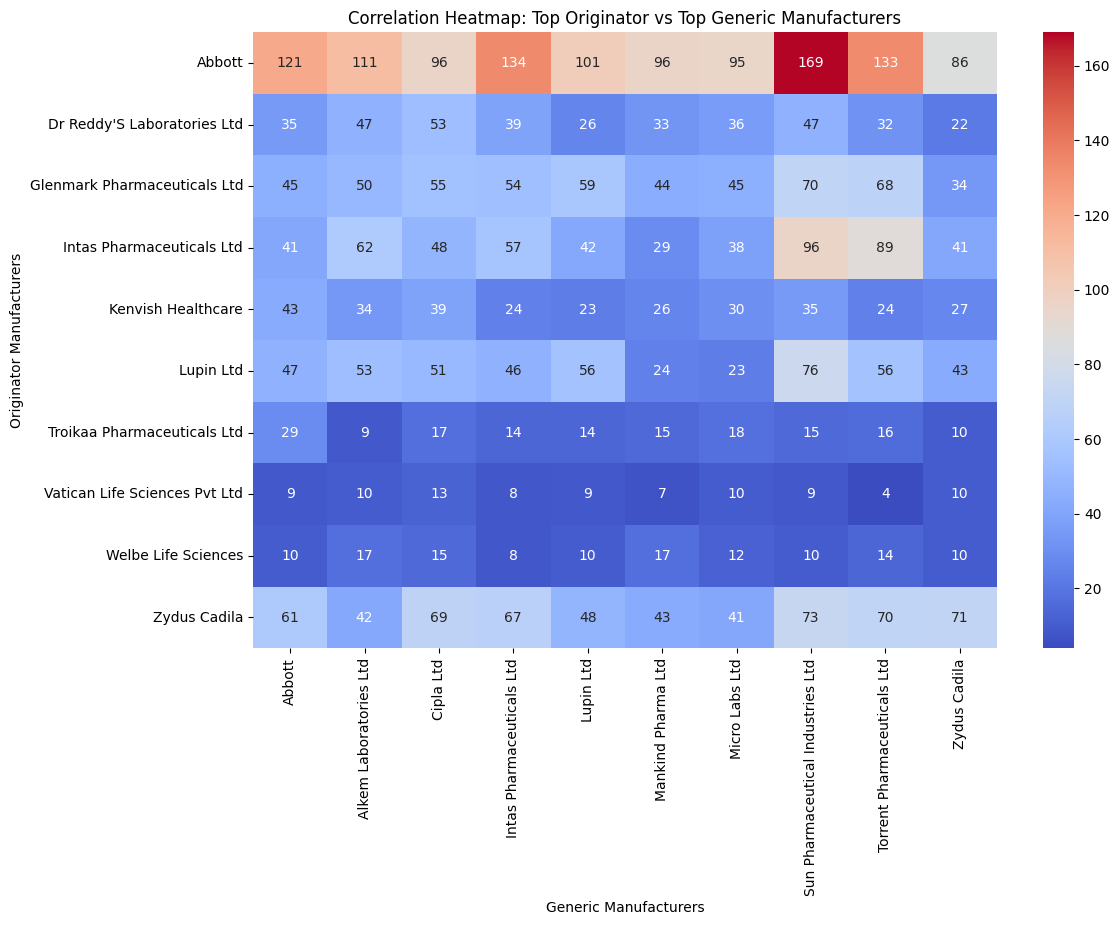

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = "/content/generic_vs_branded_analysis.csv"
df = pd.read_csv(file_path)

# Quick peek
print(df.head())
print(df.info())

# ========================
# Step 2. Price Gap Analysis
# ========================
# Overall price gap stats
gap_summary = df['price_difference_pct'].describe(percentiles=[0.25, 0.5, 0.75])
print("\n📊 Price Gap Summary:\n", gap_summary)

# Histogram of price difference %
plt.figure(figsize=(8,5))
sns.histplot(df['price_difference_pct'], bins=30, kde=True, color="royalblue")
plt.title("Distribution of Price Difference % (Originator vs Generics)")
plt.xlabel("Price Gap %")
plt.ylabel("Frequency")
plt.show()

# ========================
# Step 3. Top Manufacturers
# ========================
# Top 10 Originators
top_originators = df['originator_manufacturer'].value_counts().head(10).reset_index()
top_originators.columns = ['originator_manufacturer', 'num_drugs']

plt.figure(figsize=(10,6))
sns.barplot(data=top_originators, x="num_drugs", y="originator_manufacturer", palette="Blues_r")
plt.title("Top 10 Originator Manufacturers by Number of Drugs")
plt.xlabel("Number of Drugs")
plt.ylabel("Manufacturer")
plt.show()

# Top 10 Generics
top_generics = df['generic_manufacturer'].value_counts().head(10).reset_index()
top_generics.columns = ['generic_manufacturer', 'num_generics']

plt.figure(figsize=(10,6))
sns.barplot(data=top_generics, x="num_generics", y="generic_manufacturer", palette="Greens_r")
plt.title("Top 10 Generic Manufacturers by Number of Drugs")
plt.xlabel("Number of Generics")
plt.ylabel("Manufacturer")
plt.show()

# ========================
# Step 4. Ingredient vs Generics
# ========================
ingredient_counts = df.groupby("ingredient")["generic_brand"].nunique().reset_index()
ingredient_counts = ingredient_counts.sort_values("generic_brand", ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(data=ingredient_counts, x="generic_brand", y="ingredient", palette="magma")
plt.title("Top 20 Ingredients by Number of Generics")
plt.xlabel("Number of Generics")
plt.ylabel("Ingredient")
plt.show()

# ========================
# Step 5. Heatmap: Originators vs Generics
# ========================
# Create pivot table: how many times each generic manufacturer undercuts each originator
heatmap_df = df.groupby(["originator_manufacturer", "generic_manufacturer"]).size().reset_index(name="count")

# Pivot into a matrix
heatmap_matrix = heatmap_df.pivot(index="originator_manufacturer", columns="generic_manufacturer", values="count").fillna(0)

# Filter only top 10 originators and top 10 generics
top_originator_list = top_originators['originator_manufacturer'].tolist()
top_generic_list = top_generics['generic_manufacturer'].tolist()

heatmap_matrix = heatmap_matrix.loc[heatmap_matrix.index.intersection(top_originator_list), heatmap_matrix.columns.intersection(top_generic_list)]

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_matrix, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Correlation Heatmap: Top Originator vs Top Generic Manufacturers")
plt.xlabel("Generic Manufacturers")
plt.ylabel("Originator Manufacturers")
plt.show()

# ========================
# Step 6. Export Useful Tables
# ========================
gap_summary.to_csv("price_gap_summary.csv")
top_originators.to_csv("top_originators.csv", index=False)
top_generics.to_csv("top_generics.csv", index=False)
ingredient_counts.to_csv("ingredient_generic_counts.csv", index=False)
heatmap_matrix.to_csv("originator_vs_generic_heatmap_matrix.csv")


Basic statistical insights on the generics vs branded pricing data set

In [2]:
import pandas as pd
import numpy as np
import re
from IPython.display import display, HTML

# ---------------------------
# USER: set your file path here
# ---------------------------
FILE_PATH = '/content/generic_vs_branded_analysis.csv'  # <-- change to your uploaded filename
# ---------------------------

# ---------- helper functions ----------

def first_nonnull(series):
    s = series.dropna().unique()
    return s[0] if len(s) > 0 else np.nan


def safe_numeric(series):
    """Convert strings to numeric: remove commas, currency symbols, percent signs."""
    s = series.astype(str).str.strip()
    s = s.replace({'nan': np.nan, 'None': np.nan, '': np.nan})
    # remove any non-digit except dot and minus
    s = s.apply(lambda x: re.sub(r"[^0-9.\-]", "", x) if pd.notnull(x) else x)
    return pd.to_numeric(s, errors='coerce')


# ---------- load and clean ----------
print('Loading', FILE_PATH)
df = pd.read_csv(FILE_PATH, dtype=str)
# normalize column names (strip)
df.columns = [c.strip() for c in df.columns]
# expected columns (case-sensitive match to your description)
expected = ['ingredient','strength','dosage_form','originator_brand','originator_manufacturer',
            'originator_price','generic_brand','generic_manufacturer','generic_price',
            'price_difference','price_difference_pct','num_competitors']

missing_expected = [c for c in expected if c not in df.columns]
if missing_expected:
    print('\nWARNING: The following expected columns were not found in the CSV:')
    print(missing_expected)
    print('The script will continue but results may be incomplete. Make sure column names match exactly.')

# Trim whitespace from string columns
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()

# Convert numeric-ish columns to numeric
for col in ['originator_price','generic_price','price_difference','price_difference_pct']:
    if col in df.columns:
        df[col] = safe_numeric(df[col])

# num_competitors to integer (nullable)
if 'num_competitors' in df.columns:
    df['num_competitors'] = safe_numeric(df['num_competitors']).astype('Int64')

# If price_difference_pct is in [0..1] scale convert to percent
if 'price_difference_pct' in df.columns and df['price_difference_pct'].dropna().shape[0] > 0:
    if df['price_difference_pct'].dropna().max() <= 1:
        df['price_difference_pct'] = df['price_difference_pct'] * 100

# ---------- basic dataset overview ----------
meta = []
meta.append(('Total rows (records)', len(df)))
meta.append(('Total unique ingredients (compounds)', df['ingredient'].nunique() if 'ingredient' in df.columns else np.nan))
meta.append(('Unique originator brands', df['originator_brand'].nunique() if 'originator_brand' in df.columns else np.nan))
meta.append(('Unique originator manufacturers', df['originator_manufacturer'].nunique() if 'originator_manufacturer' in df.columns else np.nan))
meta.append(('Unique generic brands', df['generic_brand'].nunique() if 'generic_brand' in df.columns else np.nan))
meta.append(('Unique generic manufacturers', df['generic_manufacturer'].nunique() if 'generic_manufacturer' in df.columns else np.nan))
meta.append(('Unique strengths', df['strength'].nunique() if 'strength' in df.columns else np.nan))
meta.append(('Unique dosage forms', df['dosage_form'].nunique() if 'dosage_form' in df.columns else np.nan))

# missingness
missing_counts = df.isna().sum()
missing_pct = (missing_counts / len(df) * 100).round(2)
# top 5 missing columns (count and %)
top_missing = []
for c in df.columns:
    top_missing.append((c, int(missing_counts[c]), float(missing_pct[c])))

# add some missing stats
meta.append(('Columns with highest missing counts (top 5)', ', '.join([f"{c}: {cnt} ({pct}%)" for c,cnt,pct in sorted(top_missing, key=lambda x: x[1], reverse=True)[:5]])))

# ---------- competition / generics stats ----------
if 'ingredient' in df.columns and 'generic_brand' in df.columns:
    computed_generics = df.groupby('ingredient')['generic_brand'].nunique()
    meta.append(('Average number of generics (computed from generic_brand per ingredient)', round(float(computed_generics.mean()),3)))
    meta.append(('Median number of generics (computed)', float(computed_generics.median())))
    meta.append(('Std dev number of generics (computed)', round(float(computed_generics.std()),3)))
    meta.append(('Max generics for any ingredient', int(computed_generics.max())))
    meta.append(('Ingredients with zero generics', int((computed_generics==0).sum())))
    meta.append(('Ingredients with 1 generic', int((computed_generics==1).sum())))
    meta.append(('Ingredients with >=5 generics', int((computed_generics>=5).sum())))
else:
    computed_generics = pd.Series(dtype=int)

# reported num_competitors (if present) aggregated per ingredient (take first non-null per ingredient)
if 'num_competitors' in df.columns and 'ingredient' in df.columns:
    reported_by_ing = df.dropna(subset=['num_competitors']).groupby('ingredient')['num_competitors'].first()
    if reported_by_ing.shape[0] > 0:
        meta.append(('Average number of generics (reported num_competitors per ingredient)', round(float(reported_by_ing.mean()),3)))
        meta.append(('Median reported num_competitors', float(reported_by_ing.median())))

# ---------- price statistics ----------
def add_price_stats(colname, label):
    if colname in df.columns:
        s = df[colname].dropna()
        meta.append((f'{label} - non-null count', int(s.count())))
        meta.append((f'{label} - mean', round(float(s.mean()),3)))
        meta.append((f'{label} - median', round(float(s.median()),3)))
        meta.append((f'{label} - std', round(float(s.std()),3)))
        meta.append((f'{label} - min', round(float(s.min()),3)))
        meta.append((f'{label} - max', round(float(s.max()),3)))

add_price_stats('originator_price', 'Originator price (currency units)')
add_price_stats('generic_price', 'Generic price (currency units)')
add_price_stats('price_difference', 'Price difference (originator - generic)')
add_price_stats('price_difference_pct', 'Price difference % (pct)')

# Per-ingredient undercut analysis (median-based)
if all(col in df.columns for col in ['ingredient','originator_price','generic_price']):
    ing = df.groupby('ingredient').agg(
        originator_price_median=('originator_price','median'),
        generic_price_median=('generic_price','median'),
        num_generics_computed=('generic_brand', pd.Series.nunique),
        originator_brand=('originator_brand', lambda x: first_nonnull(x)),
        originator_manufacturer=('originator_manufacturer', lambda x: first_nonnull(x))
    )
    # compute undercut percentage
    ing['undercut_pct'] = (ing['originator_price_median'] - ing['generic_price_median']) / ing['originator_price_median'] * 100
    # handle division by zero or NaN
    ing['undercut_pct'] = ing['undercut_pct'].replace([np.inf, -np.inf], np.nan)

    meta.append(('Ingredients with valid median originator & generic price (used for undercut analysis)', int(ing['undercut_pct'].dropna().shape[0])))
    meta.append(('Average median-based undercut % (positive means generics cheaper)', round(float(ing['undercut_pct'].mean()),3)))
    meta.append(('Median median-based undercut %', round(float(ing['undercut_pct'].median()),3)))
    meta.append(('Ingredients where median generic price >= median originator price', int((ing['generic_price_median'] >= ing['originator_price_median']).sum())))
else:
    ing = pd.DataFrame()

# ---------- manufacturer and brand insights ----------
if 'originator_manufacturer' in df.columns:
    originator_manu_counts = df.groupby('originator_manufacturer')['ingredient'].nunique().sort_values(ascending=False)
    meta.append(('Top originator manufacturers by unique ingredients (top 5)', ', '.join([f"{m} ({int(v)})" for m,v in originator_manu_counts.head(5).items()])))
if 'generic_manufacturer' in df.columns:
    generic_manu_counts = df.groupby('generic_manufacturer')['generic_brand'].nunique().sort_values(ascending=False)
    meta.append(('Top generic manufacturers by unique generic brands (top 5)', ', '.join([f"{m} ({int(v)})" for m,v in generic_manu_counts.head(5).items()])))

# ---------- competition winners & risk signals ----------
# top N most competed ingredients
if computed_generics.shape[0] > 0:
    top_competed = computed_generics.sort_values(ascending=False).head(10)
    meta.append(('Top 10 most competed ingredients (ingredient: num generics)', ', '.join([f"{i}: {int(n)}" for i,n in top_competed.items()])))

# ingredients with largest undercut opportunity as percent
if 'undercut_pct' in ing.columns:
    big_undercut = ing['undercut_pct'].dropna().sort_values(ascending=False).head(10)
    meta.append(('Top 10 largest median undercut % (ingredient: pct)', ', '.join([f"{i}: {round(p,1)}%" for i,p in big_undercut.items()])))

# ---------- packaging metadata into DataFrame ----------
metadata_df = pd.DataFrame(meta, columns=['metric','value'])

# ---------- ingredient-level summary DataFrame for presentation ----------
# Build a tidy per-ingredient table with relevant stats
if ing.shape[0] > 0:
    ingredient_summary = ing.copy()
    # add additional stats: computed average originator price (mean), number of records
    extra = df.groupby('ingredient').agg(total_records=('ingredient','size'),
                                         originator_price_mean=('originator_price','mean'),
                                         generic_price_mean=('generic_price','mean'))
    ingredient_summary = ingredient_summary.join(extra)
    # reorder columns for readability
    cols_order = ['total_records','num_generics_computed','originator_brand','originator_manufacturer',
                  'originator_price_mean','originator_price_median','generic_price_mean','generic_price_median','undercut_pct']
    ingredient_summary = ingredient_summary[[c for c in cols_order if c in ingredient_summary.columns]]
    ingredient_summary = ingredient_summary.reset_index().rename(columns={'index':'ingredient'})
else:
    ingredient_summary = pd.DataFrame()

# ---------- save to CSV ----------
metadata_df.to_csv('/content/metadata_summary.csv', index=False)
if ingredient_summary.shape[0] > 0:
    ingredient_summary.to_csv('/content/ingredient_summary.csv', index=False)

# ---------- display results ----------
print('\n=== Metadata table (dataset-level) ===')
display(metadata_df)

if ingredient_summary.shape[0] > 0:
    print('\n=== Ingredient-level summary (first 50 rows) ===')
    display(ingredient_summary.head(50))
    print('\nSaved: /content/ingredient_summary.csv')

print('\nSaved: /content/metadata_summary.csv')

print('\nNext steps / suggestions:')
print('- If you want visualizations: distribution of number-of-generics, histogram of undercut_pct, heatmap of manufacturers vs number of ingredients.')
print("- For a conference-ready table, set 'ingredient_summary.to_excel('/content/ingredient_summary.xlsx', index=False)' and download from Colab.")

print('\nScript finished.')

Loading /content/generic_vs_branded_analysis.csv

=== Metadata table (dataset-level) ===


,metric,value
0,Total rows (records),221387
1,Total unique ingredients (compounds),1051
2,Unique originator brands,4343
3,Unique originator manufacturers,1218
4,Unique generic brands,218136
5,Unique generic manufacturers,7312
6,Unique strengths,379
7,Unique dosage forms,15
8,Columns with highest missing counts (top 5),"ingredient: 0 (0.0%), strength: 0 (0.0%), dosa..."
9,Average number of generics (computed from gene...,207.647



=== Ingredient-level summary (first 50 rows) ===


,ingredient,total_records,num_generics_computed,originator_brand,originator_manufacturer,originator_price_mean,originator_price_median,generic_price_mean,generic_price_median,undercut_pct
0,Abacavir,8,7,Virol 300mg Tablet,Sun Pharmaceutical Industries Ltd,6351.156250,5832.850,2252.517500,2192.080,62.418372
1,Abciximab,2,2,Reopro 10mg Injection,Eli Lilly And Company India Pvt Ltd,22629.000000,22629.000,8700.000000,8700.000,61.553758
2,Abemaciclib,1,1,Ramiven 200mg Tablet,Eli Lilly And Company India Pvt Ltd,23876.000000,23876.000,11938.000000,11938.000,50.000000
3,Abiraterone Acetate,49,45,Zytiga 250mg Tablet,Janssen Pharmaceuticals,120285.714286,150000.000,30819.103469,28000.000,81.333333
4,Acamprosate,7,7,Acampcon 333 Tablet,Consern Pharma Limited,137.000000,137.000,104.937143,106.000,22.627737
5,Acarbose,81,81,GLUCOBAY 100 MG TABLET,Bayer Zydus Pharma Pvt Ltd,144.644444,168.000,81.300247,77.000,54.166667
6,Acebrophylline,581,578,Bicebro 100mg Capsule,Bio Heal Remedies,713.352151,379.000,130.197435,106.700,71.846966
7,Aceclofenac,8551,8501,Bextrin Total Capsule,Pharmanova India Drugs Pvt Ltd,505.694286,562.600,75.355171,65.000,88.446498
8,Acenocoumarol,40,40,Acitrom 1 Tablet,Abbott,343.082000,264.740,82.128500,66.300,74.956561
9,Acetazolamide,27,27,Avva Capsule SR,Intas Pharmaceuticals Ltd,87.500000,87.500,39.890741,38.400,56.114286



Saved: /content/ingredient_summary.csv

Saved: /content/metadata_summary.csv

Next steps / suggestions:
- If you want visualizations: distribution of number-of-generics, histogram of undercut_pct, heatmap of manufacturers vs number of ingredients.
- For a conference-ready table, set 'ingredient_summary.to_excel('/content/ingredient_summary.xlsx', index=False)' and download from Colab.

Script finished.
